In [4]:
working_on_kaggle = True

In [5]:
repo_name = "PDLPR-algorithm"

if working_on_kaggle:
    !pip install --quiet gdown
    !apt-get install -y fonts-noto-cjk > /dev/null

    import os

    git_url = f"https://github.com/giankev/{repo_name}.git"
    os.system(f"git clone {git_url} /kaggle/working/{repo_name}")
    %cd PDLPR-algorithm/

Cloning into '/kaggle/working/PDLPR-algorithm'...


/kaggle/working/PDLPR-algorithm


# Import

In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import torch
from torch.utils.data import DataLoader 
from sklearn.model_selection import train_test_split

import sys
sys.path.append('./scr/')
from pdlpr import PDLPR 
from trainer import train, set_seed, evaluate_pdlpr, infer_and_evaluate_pdlpr
from trainer import PlateDataset
from augmentation import transform_night, transform_day, transform_fn, transform_blur, transform_rot, transform_tilt_1, transform_tilt_2, transform_challenge, val_transform

from utility import char2idx, idx2char, num_classes
from utility import create_dataframe, create_cropped_dataframe, download_and_extract_dataset, plot_batch_images


In [ ]:
#NOTE: To download the best checkpoint for the PDLPR algorithm, uncomment and run this section

# !pip install -q gdown
# import gdown

# file_id = "19wevTLaCCklKl9x52NgXgvHfRpzfR1yr"
# output = "/kaggle/working/PDLPR-algorithm/checkpoints/pdlpr/checkpoint_epoch105.pt"
# os.makedirs(os.path.dirname(output), exist_ok=True)
# gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Globals

In [8]:
# Hyperparameters and Configurations
NUM_WORKERS = 0
SEED = 42 # Random seed for reproducibility
BATCH_SIZE = 128
TEST_BATCH_SIZE = 5
VAL_SPLIT_SIZE = 0.02 # Percentage of data to use for validation
NUM_SAMPLES = 50000  # Number of samples to use from dataset

# Training parameters
num_epochs = 105  # Set to 0 to skip training
lr = 1e-4      # Learning rate
lr_decay_factor = 0.9  
lr_decay_epochs = 20  # Decay LR every 20 epochs by the decay factor

# Set the seed for reproducibility
set_seed(SEED)

save_checkpoint_path = "checkpoints/pdlpr/" # Folder to save model checkpoints
name_checkpoint = None # Name of checkpoint (e.g. "checkpoint_epoch105.pt") to load (or None)

# Full path to checkpoint file to load (if provided)
if name_checkpoint is not None:
    load_checkpoint_path =  os.path.join(save_checkpoint_path, name_checkpoint) 
else:
    load_checkpoint_path = None

# Dataset and output paths
extract_path = 'dataset'
output_path = 'dataset/ccpd_subset_base.tar'
folder_path = os.path.join(extract_path, 'ccpd_subset_base', 'train')
cropped_folder = "dataset/ccpd_cropped"
font_path =  "C:/Windows/Fonts/msyh.ttc"

# Adjust paths for Kaggle environment
kaggle_working_folder = '/kaggle/working/' + repo_name
if working_on_kaggle:
    NUM_WORKERS = 2  # Enable parallel data loading on Kaggle
    print("Creating ", save_checkpoint_path)
    save_checkpoint_path = os.path.join(kaggle_working_folder, save_checkpoint_path)
    os.makedirs(save_checkpoint_path, exist_ok=True)
    
    if load_checkpoint_path is not None:
        load_checkpoint_path = os.path.join(save_checkpoint_path, name_checkpoint)

    output_path = os.path.join(kaggle_working_folder, output_path)
    extract_path = os.path.join(kaggle_working_folder, extract_path)
    folder_path = os.path.join(extract_path, 'ccpd_subset_base', 'train')
    cropped_folder = os.path.join(kaggle_working_folder, cropped_folder)
    font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"

# Load font properties for plotting
prop = fm.FontProperties(fname=font_path)
# Ensure output and cropped directories exist
os.makedirs(os.path.dirname(output_path), exist_ok=True)
os.makedirs(cropped_folder, exist_ok=True)


# Ensure the checkpoint file exists if we are trying to load it
if load_checkpoint_path is not None and not os.path.isfile(load_checkpoint_path):
    raise FileNotFoundError(f"Checkpoint file not found: {load_checkpoint_path}")
    

Creating  checkpoints/pdlpr/


# Dataset

## Download and extraction

In [ ]:
# Download and Extract Datase
file_id = "1RGEnfa5xWhDzO6oSoECQwQwyP4BRH5d_"
url = f'https://drive.google.com/uc?id={file_id}'

# Download and extract the dataset into the specified folder
download_and_extract_dataset(url, output_path, extract_path, folder_path)

# If running on Kaggle, remove the .tar file after extraction to save disk space
if working_on_kaggle:
    if os.path.exists(output_path):
        os.remove(output_path)

Downloading...
From (original): https://drive.google.com/uc?id=1RGEnfa5xWhDzO6oSoECQwQwyP4BRH5d_
From (redirected): https://drive.google.com/uc?id=1RGEnfa5xWhDzO6oSoECQwQwyP4BRH5d_&confirm=t&uuid=7c12f55e-a712-4463-bfaa-b8e5616a80d1
To: /kaggle/working/PDLPR-algorithm/dataset/ccpd_subset_base.tar
100%|██████████| 3.76G/3.76G [00:36<00:00, 105MB/s] 


Extracting the dataset...
Extraction completed.


In [10]:
df = create_dataframe(folder_path, char2idx)
df = df[:NUM_SAMPLES]

df.head()

,image_path,x1_bbox,y1_bbox,x2_bbox,y2_bbox,plate_number,label
0,/kaggle/working/PDLPR-algorithm/dataset/ccpd_s...,341,443,436,482,皖AK9954,"[52, 11, 20, 10, 10, 6, 5]"
1,/kaggle/working/PDLPR-algorithm/dataset/ccpd_s...,413,479,530,520,皖ALX575,"[52, 11, 21, 32, 6, 8, 6]"
2,/kaggle/working/PDLPR-algorithm/dataset/ccpd_s...,276,480,370,520,皖A65L62,"[52, 11, 7, 6, 21, 7, 3]"
3,/kaggle/working/PDLPR-algorithm/dataset/ccpd_s...,224,566,311,607,皖A0X654,"[52, 11, 1, 32, 7, 6, 5]"
4,/kaggle/working/PDLPR-algorithm/dataset/ccpd_s...,310,528,419,577,皖AMC629,"[52, 11, 22, 13, 7, 3, 10]"


## Crop and resize

In [11]:
# Creating a DataFrame with the cropped images
if os.path.isdir(cropped_folder):
    num_files = len([f for f in os.listdir(cropped_folder) if os.path.isfile(os.path.join(cropped_folder, f))])
    print(f"Found {num_files} files in '{cropped_folder}' (expected: {NUM_SAMPLES})")

    if num_files == NUM_SAMPLES:
        print("Cropped folder already processed. Skipping cropping step.")
    else:
        print("Cropped folder incomplete. Reprocessing...")
        cropped_df = create_cropped_dataframe(df, cropped_folder)
else:
    print(f"The folder '{cropped_folder}' doesn't exist. Creating and processing...")
    os.makedirs(cropped_folder, exist_ok=True)
    cropped_df = create_cropped_dataframe(df, cropped_folder)

Found 0 files in '/kaggle/working/PDLPR-algorithm/dataset/ccpd_cropped' (expected: 50000)
Cropped folder incomplete. Reprocessing...


100%|██████████| 50000/50000 [02:42<00:00, 308.29it/s]


## DataLoader and Augmentation

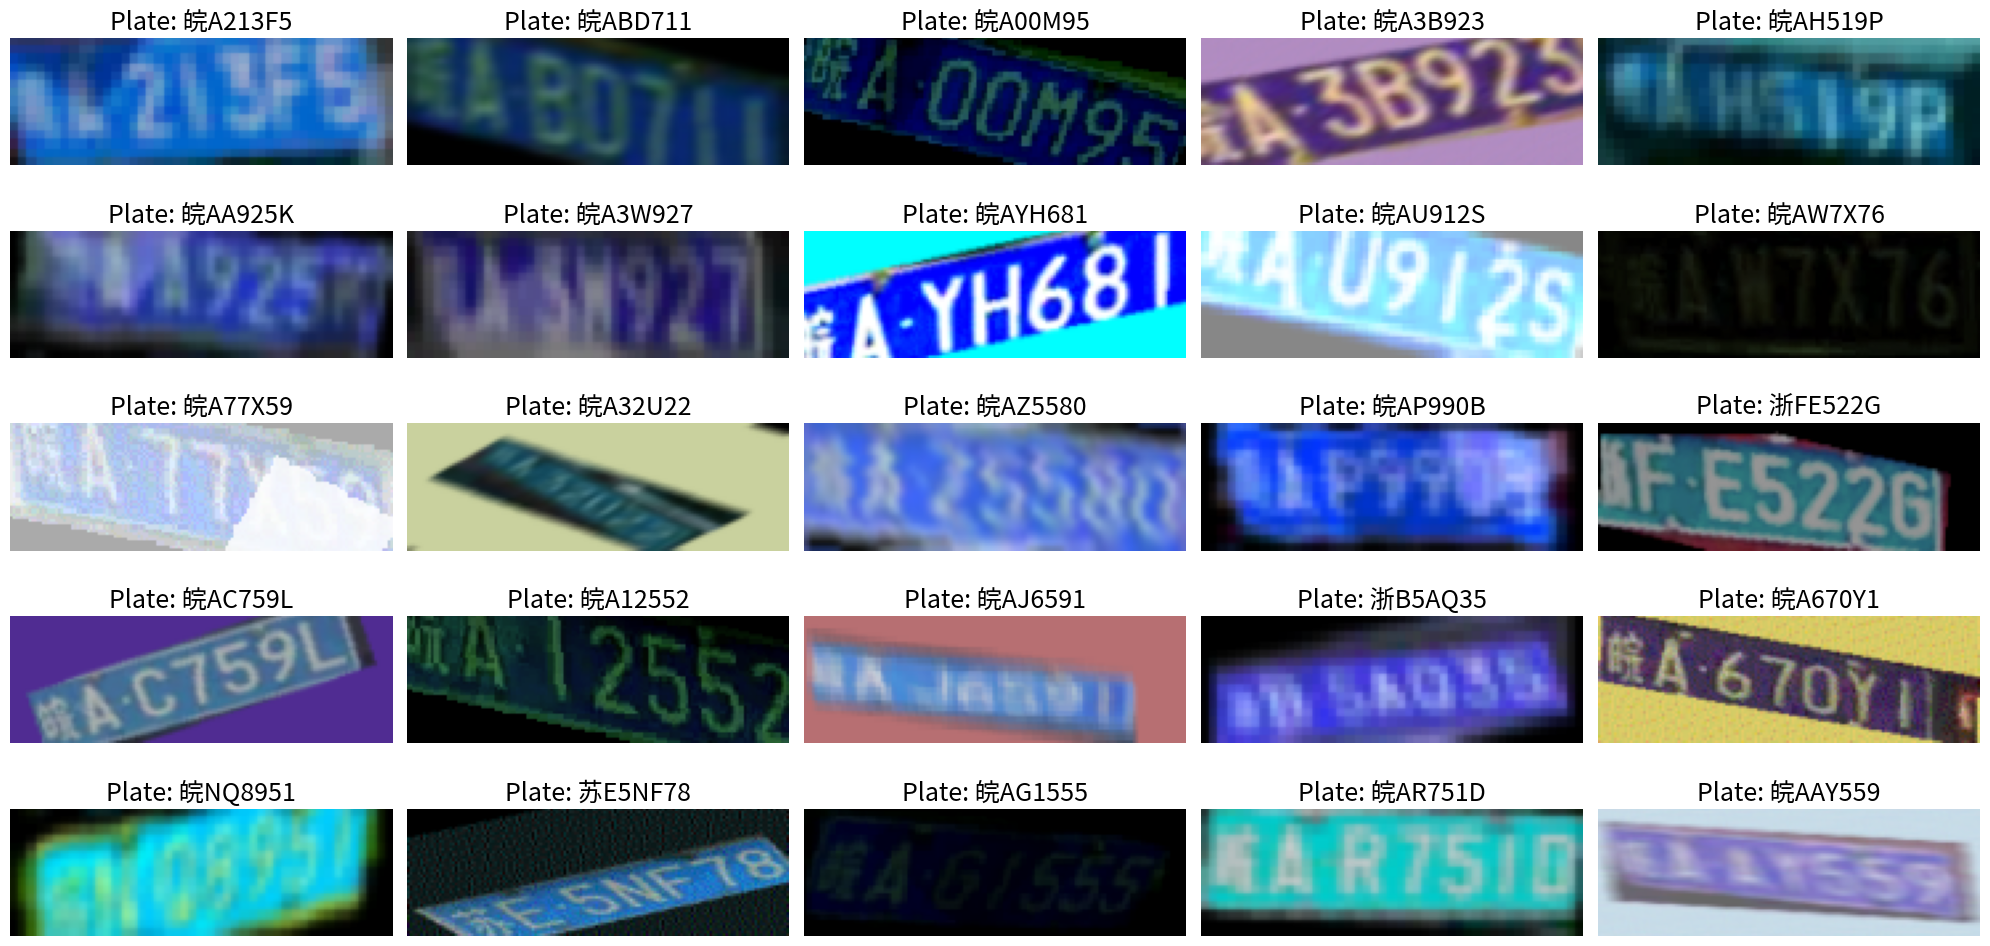

In [ ]:
# Split the cropped dataframe into training and validation sets
train_df, val_df = train_test_split(cropped_df, test_size=VAL_SPLIT_SIZE, shuffle=True, random_state=SEED)

# List of data augmentation functions for the training set
transform_list = [
    transform_night,
    transform_day,
    transform_fn,
    transform_blur,
    transform_tilt_1,
    transform_tilt_2,
    transform_rot,
    transform_challenge
]

# Create the augmented training dataset
augmented_dataset = PlateDataset(train_df, transform=transform_list)
# DataLoader for the training dataset
train_loader = DataLoader(augmented_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

# Validation dataset with only standard validation transformations
val_dataset = PlateDataset(val_df, transform=val_transform)
# DataLoader for the validation dataset
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Visualize a batch of training images
plot_batch_images(train_loader, idx2char, font=prop)

# Training

In [13]:
# Select device: use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = PDLPR(num_classes=num_classes)
model = model.to(device)  

# Train the model and get training/validation loss history
print("Start training...")
model, train_losses, val_losses = train(train_loader, val_loader, model, char2idx, device, num_epochs,
      lr, load_checkpoint_path, save_checkpoint_path, lr_decay_factor, lr_decay_epochs)

Start training...
Checkpoint loaded /kaggle/working/PDLPR-algorithm/checkpoints/pdlpr/checkpoint_epoch105.pt, resuming from epoch 105
Training completed.


# Test set

In [18]:
# Test Set Paths
test_output_path = 'dataset/ccpd_test.tar'
test_extract_path = 'dataset'
test_folder_path = os.path.join(test_extract_path, 'ccpd_test')
test_cropped_folder = 'dataset/ccpd_test_cropped'

# Adapt to work on kaggle
if working_on_kaggle:
    test_output_path = os.path.join(kaggle_working_folder, test_output_path)

    test_extract_path = os.path.join(kaggle_working_folder, test_extract_path)
    test_folder_path = os.path.join(test_extract_path, 'ccpd_test')
    test_cropped_folder = os.path.join(kaggle_working_folder, test_cropped_folder)

# Create folder if they don't exist
os.makedirs(os.path.dirname(test_output_path), exist_ok=True)
os.makedirs(test_cropped_folder, exist_ok=True)

# Download and extract the test set from Google Driv
file_id_test = "1rlOc7X2_C9vq2sm1ULBjNAgb_gy6CP8R" # Mattia
# file_id_test = '1PnYtN0P6m36LmjztvhVmVLqZwZAp9Q3X'# Kevin
# file_id_test = "1n1RAP_4MSPUw6hOASU48NHIzVFfRdII5"  5K samples

url_test = f'https://drive.google.com/uc?id={file_id_test}'
download_and_extract_dataset(url_test, test_output_path, test_extract_path, test_folder_path)

#List available subfolders inside the test dataset
if os.path.exists(test_folder_path):
    subfolders = [name for name in os.listdir(test_folder_path)
                  if os.path.isdir(os.path.join(test_folder_path, name))]
    subfolders = sorted(subfolders)
    print(f"Subfolders in '{test_folder_path}':")
else:
    print(f"The folder '{test_folder_path}' does not exist.")

for subfolder in subfolders:
    print(f"\nEvaluation on CCPD_{subfolder}")
    subfolder_path = os.path.join(test_folder_path, subfolder) 
    # Create dataframe from image folder
    sub_df = create_dataframe(subfolder_path, char2idx)
    # Crop plates and create a new dataframe
    cropped_subfolder =  os.path.join(test_cropped_folder, subfolder)
    os.makedirs(cropped_subfolder, exist_ok=True)
    cropped_sub_df = create_cropped_dataframe(sub_df, cropped_subfolder)
    # Prepare dataset and dataloader
    test_dataset = PlateDataset(cropped_sub_df, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    # Evaluate model performance on the test data
    test_loss, test_char_acc, test_seq_acc, avg_fps = evaluate_pdlpr(model, test_loader, char2idx, "cuda")

Dataset already exists, download skipped.
Dataset folder already exists, extraction skipped.
Subfolders in '/kaggle/working/PDLPR-algorithm/dataset/ccpd_test':

Evaluation on CCPD_base
Evaluation | Loss: 0.0029 | Char Acc: 0.9997 | Seq Acc: 0.9980 | FPS: 312.27

Evaluation on CCPD_blur
Evaluation | Loss: 0.0561 | Char Acc: 0.9821 | Seq Acc: 0.9060 | FPS: 311.25

Evaluation on CCPD_challenge
Evaluation | Loss: 0.0756 | Char Acc: 0.9806 | Seq Acc: 0.8960 | FPS: 307.33

Evaluation on CCPD_db
Evaluation | Loss: 0.1337 | Char Acc: 0.9701 | Seq Acc: 0.8470 | FPS: 305.69

Evaluation on CCPD_fn
Evaluation | Loss: 0.1394 | Char Acc: 0.9804 | Seq Acc: 0.9050 | FPS: 316.49

Evaluation on CCPD_rotate
Evaluation | Loss: 0.0840 | Char Acc: 0.9884 | Seq Acc: 0.9390 | FPS: 315.44

Evaluation on CCPD_tilt
Evaluation | Loss: 0.1019 | Char Acc: 0.9771 | Seq Acc: 0.8690 | FPS: 306.90

Evaluation on CCPD_weather
Evaluation | Loss: 0.0093 | Char Acc: 0.9983 | Seq Acc: 0.9880 | FPS: 316.58


# Evaluation on specific dataset

In [15]:
for subfolder in subfolders:
    if subfolder == "tilt":
        print(f"\nEvaluation on CCPD_{subfolder}")
        subfolder_path = os.path.join(test_folder_path, subfolder) 
        
        sub_df = create_dataframe(subfolder_path, char2idx)
    
        cropped_subfolder =  os.path.join(test_cropped_folder, subfolder)
        os.makedirs(cropped_subfolder, exist_ok=True)
        cropped_sub_df = create_cropped_dataframe(sub_df, cropped_subfolder)
    
        test_dataset = PlateDataset(cropped_sub_df, transform=val_transform)
        test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=NUM_WORKERS)
        
        test_loss, test_char_acc, test_seq_acc, fps = evaluate_pdlpr(model, test_loader, char2idx, "cuda")


Evaluation on CCPD_tilt
Evaluation | Loss: 0.1009 | Char Acc: 0.9771 | Seq Acc: 0.8690 | FPS: 497.92


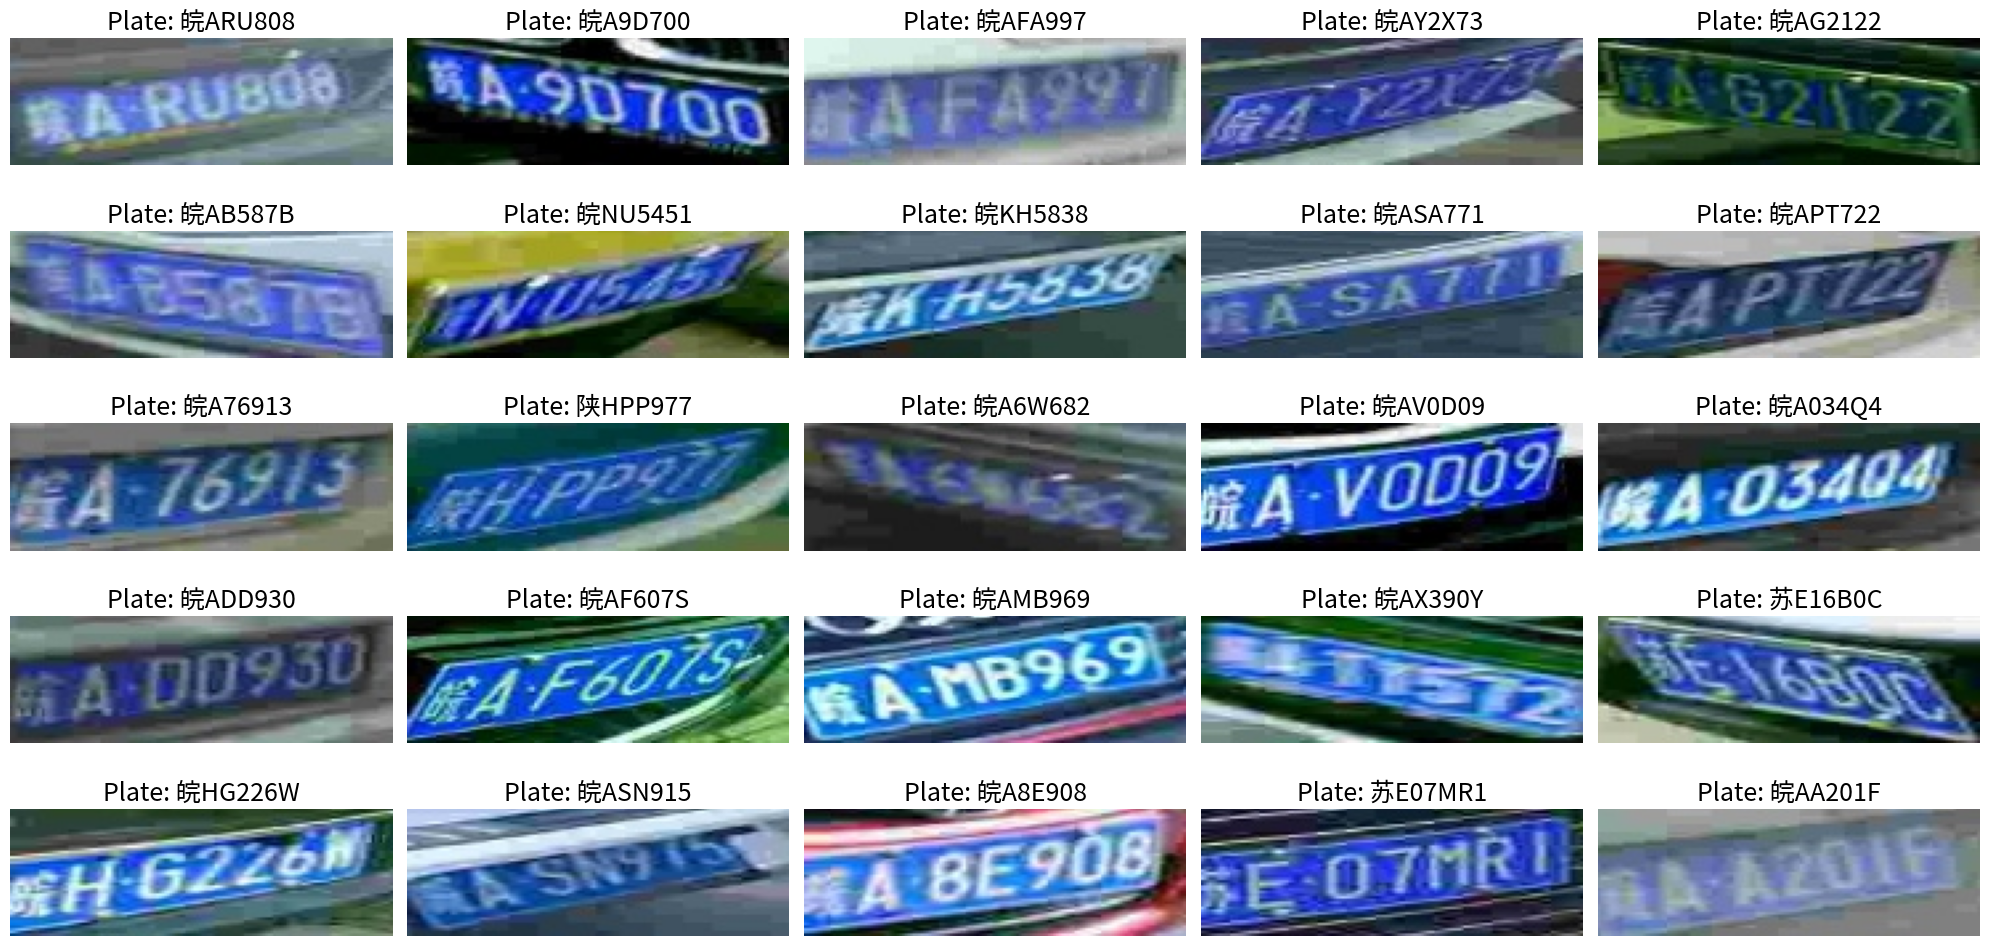

In [16]:
plot_batch_images(test_loader, idx2char, prop)

2


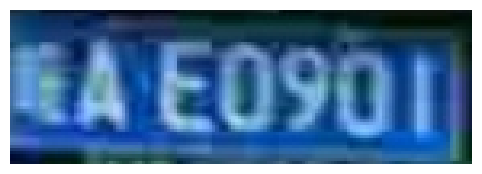

Raw sequence (argmax per timestep): 皖A-E-----0---9-0-1
Predetta:          皖AE0901
Target:            皖AE0901
CTC Loss:          0.0000
Len pred:          7, Len true: 7
Character Accuracy: 1.0000
Sequence Accuracy:  1


In [19]:
# Get one batch of images and labels from the test loader
images, labels = next(iter(test_loader))

# Select a random index from the batch
i = np.random.randint(0, len(images))
print(i)

# Select the image and its corresponding label by index
first_image = images[i]
first_label = labels[i]

# Show the image
plt.figure(figsize=(10, 2))

# Images always have 3 channels (RGB), so just transpose for plotting
plt.imshow(np.transpose(first_image.cpu().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

# Run inference on the selected image and evaluate the prediction
decoded_str, loss_value = infer_and_evaluate_pdlpr(model, first_image, first_label, char2idx, idx2char)
